# Exercise 8 Reinforcement Learning I 
## Céline Budding && Dorothea Müller 

In [1]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

%matplotlib inline

## 1. The 10-armed bandit

### 1.

In [2]:
reward_prob = np.random.uniform(0, 0.9, 10)
reward_prob

array([0.75806873, 0.57576389, 0.38651968, 0.0127694 , 0.06019078,
       0.57501154, 0.75726222, 0.31342424, 0.83477488, 0.17942196])

### 2.

In [3]:
def generate_reward(reward_prob, lever_numbers):
    rewards = np.zeros(len(lever_numbers))
    for i, lever_number in enumerate(lever_numbers):
        if np.random.random() > reward_prob[lever_number]:
            rewards[i] = 0
        else:
            rewards[i] = 1
    return rewards

In [4]:
# Testing.
n = 10000
received_rewards = np.zeros(len(reward_prob))
for i in range(n):
    received_rewards += generate_reward(reward_prob, np.arange(0, 10))
received_rewards/=n

In [5]:
received_rewards

array([0.76  , 0.5742, 0.3932, 0.0141, 0.0586, 0.5916, 0.752 , 0.3218,
       0.838 , 0.1816])

### 3.

In [6]:
def update_q(reward, pos, q, eta = 0.01):
    delta_q = eta * (reward - q[pos])
    q[pos] += delta_q
    return q

In [7]:
q = np.zeros(len(reward_prob))

In [8]:
for i in range(n):
    # Pulling the levers at all positions.
    q = update_q(reward_prob, np.arange(len(q)), q)
q

array([0.75806873, 0.57576389, 0.38651968, 0.0127694 , 0.06019078,
       0.57501154, 0.75726222, 0.31342424, 0.83477488, 0.17942196])

### 4.

In [9]:
def eps_greedy(q, eps):
    """Return lever(s) to be pressed, q value of chosen lever, largest q value."""
    if np.random.random() < 1-eps:
        # Get all the maxima.
        pos = np.argwhere(q == np.amax(q)).flatten()
        val = np.take(q, pos, 0)[0]
        largest_val = val
    else:
        pos = np.random.randint(0, len(q))
        val = q[pos]
        largest_val = q[np.argmax(q)]
        pos = np.array([pos])
        
    return [pos, val, largest_val]

### 5.

In [10]:
def pure_greedy_seq():
    q = np.zeros(len(reward_prob))

    n = 1000
    expected_reward = np.zeros(n)

    for i in range(n):
        levers = eps_greedy(q, 0)
        pos = levers[0]
        reward = generate_reward(reward_prob, pos)
        q = update_q(reward, pos, q)

        expected_reward[i] = levers[1]
    
    return expected_reward

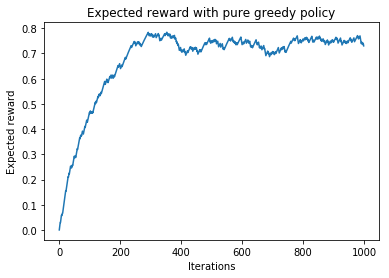

In [11]:
expected_reward = pure_greedy_seq()
plt.plot(expected_reward)
plt.xlabel('Iterations')
plt.ylabel('Expected reward')
plt.title("Expected reward with pure greedy policy")
plt.show()

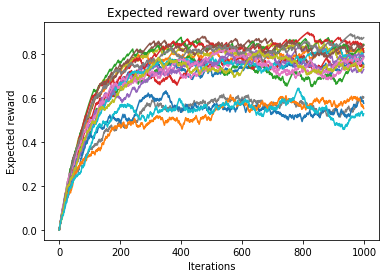

In [12]:
for i in range(20):
    expected_reward = pure_greedy_seq()
    plt.plot(expected_reward)
plt.xlabel('Iterations')
plt.ylabel('Expected reward')
plt.title("Expected reward over twenty runs")
plt.show()

**Does the agent
consistently identify the levers with the largest reward probabilities?**

No.

### 6.

In [13]:
def get_seq(param, q = q, reward_prob = reward_prob, policy_fnc = eps_greedy, n = n, reward_fnc = generate_reward):
    q = np.zeros(len(reward_prob))

    expected_reward = np.zeros(n)
    max_reward = np.zeros(n)

    for i in range(n):
        levers = policy_fnc(q, param)
        pos = levers[0]
        reward = reward_fnc(reward_prob, pos)
        q = update_q(reward, pos, q)

        expected_reward[i] = levers[1]
        max_reward[i] = levers[2]
    
    return expected_reward, max_reward

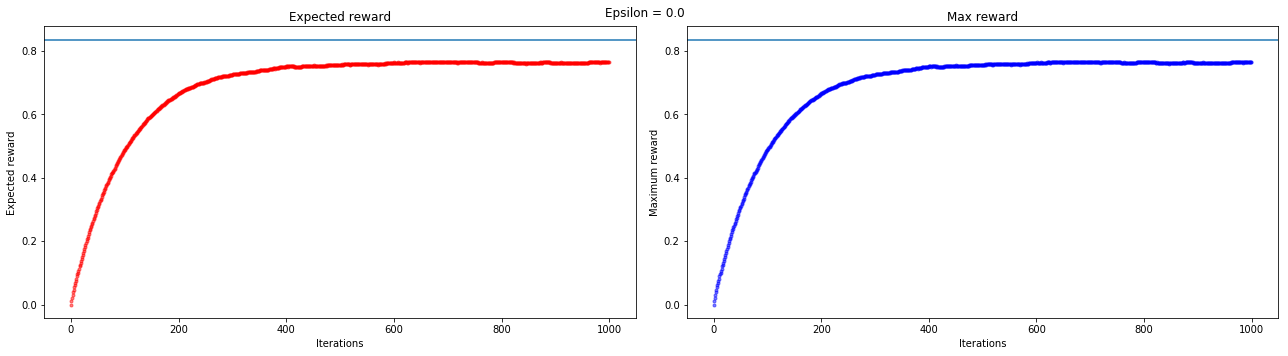

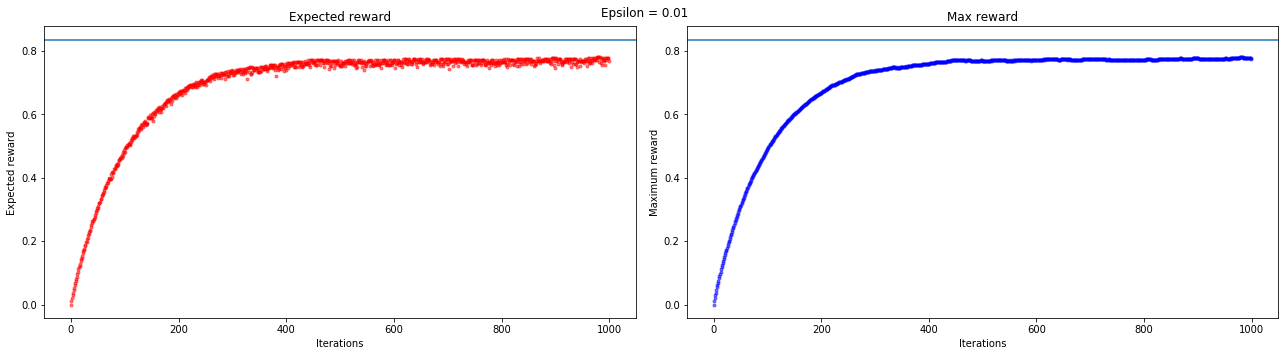

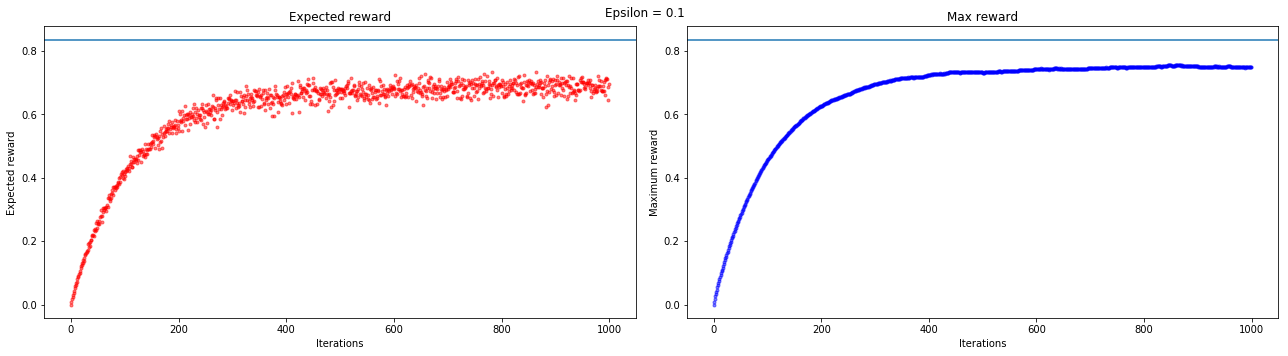

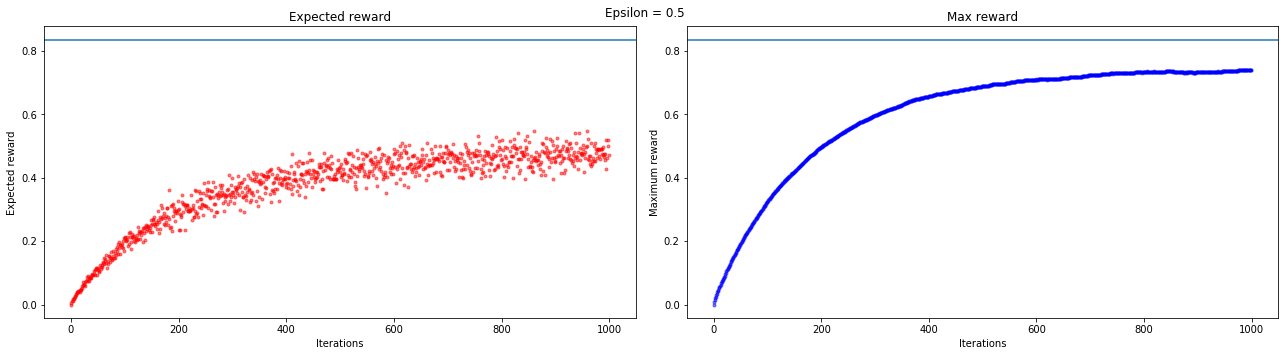

In [14]:
all_eps = [0.0, 0.01, 0.1, 0.5]

n = 1000
expected_reward = np.zeros(n)
max_reward = np.zeros(n)
lifes = 100

for eps in all_eps:
    for life in range(lifes):
        expected_reward_one_life, max_reward_one_life = get_seq(param = eps, n = n)
        expected_reward += expected_reward_one_life
        max_reward += max_reward_one_life
        
    expected_reward/= lifes
    max_reward/= lifes
    
    fig, axs = plt.subplots(1, 2, figsize = (18, 5))
    axs[0].plot(expected_reward, 'ro', markersize=3, alpha = 0.5)
    axs[0].set_title("Expected reward")
    axs[0].set_xlabel('Iterations')
    axs[0].set_ylabel('Expected reward')
    axs[0].axhline(np.max(reward_prob))
    
    axs[1].plot(max_reward, 'bo', markersize=3, alpha = 0.5)
    axs[1].set_title("Max reward")
    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('Maximum reward')
    axs[1].axhline(np.max(reward_prob))

    plt.suptitle(f"Epsilon = {eps}")
    
    fig.tight_layout()
    plt.show()

**Why the looks?**

We need more time to converge for larger epsilon as the chance for taking a random negative action is higher. This is why it makes sense to adapt the epsilon to a lower value for lower lifetimes. 

### 7.

In [15]:
def softmax(q, beta):
    """Return position of lever, value at this position and maximum q-value."""
    p = np.exp(beta * q)/np.sum(np.exp(beta * q))
    p_cum = np.cumsum(p)
    
    rand_el = np.random.random()
    pos =  np.argwhere(p_cum > rand_el)[0]
    val = q[pos][0]
    max_val = np.max(q)
    
    return [pos, val, max_val]

In [16]:
# Testing.
q = np.array([0.2, 0.5, 0.3])
softmax(q, 1)

[array([1], dtype=int64), 0.5, 0.5]

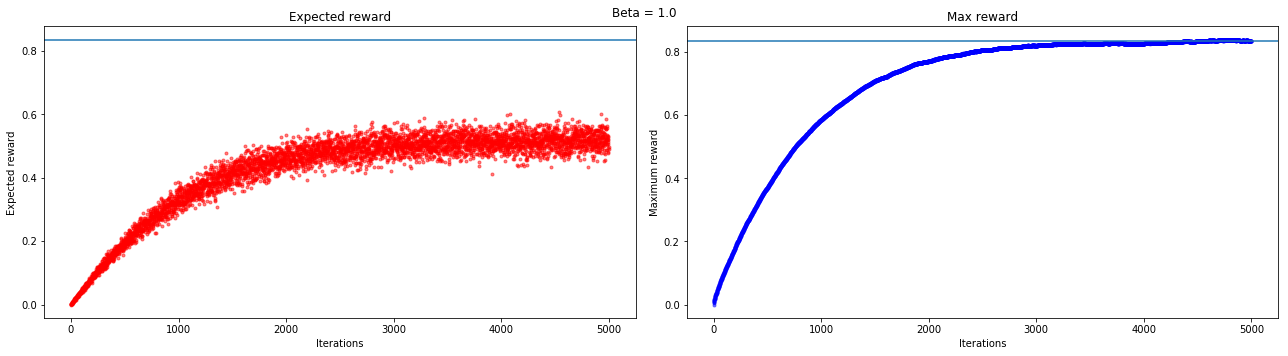

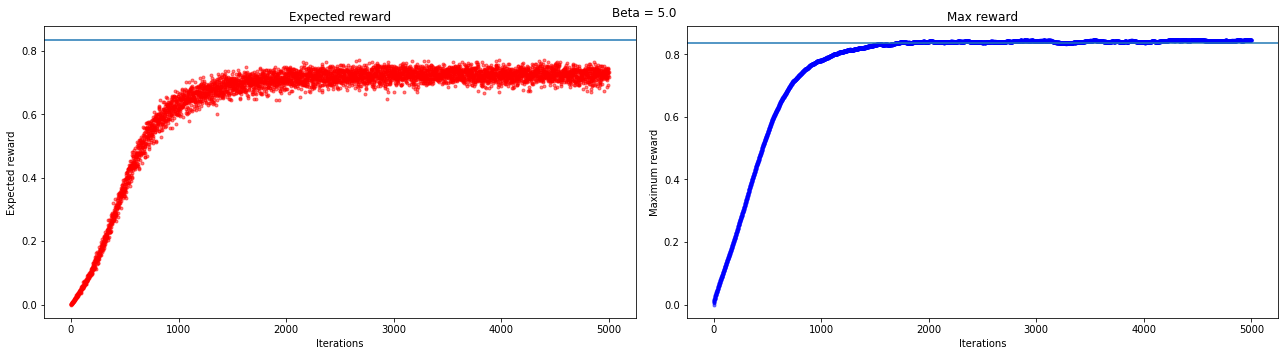

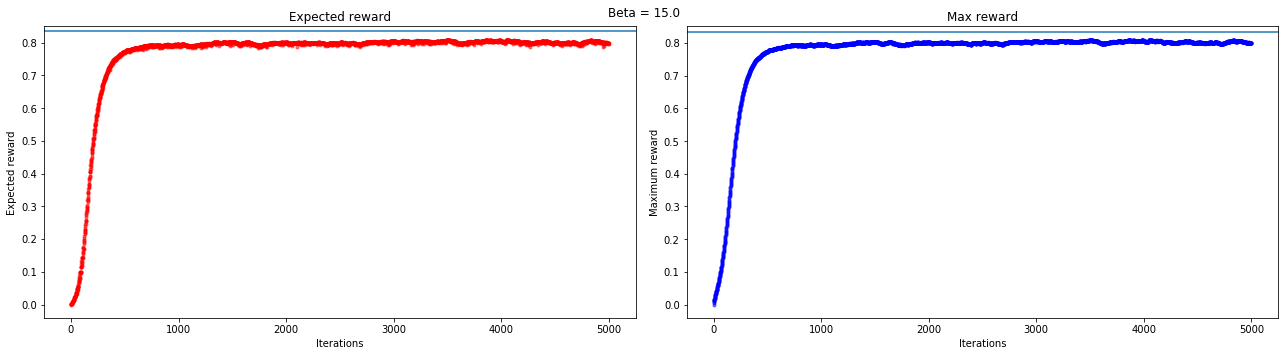

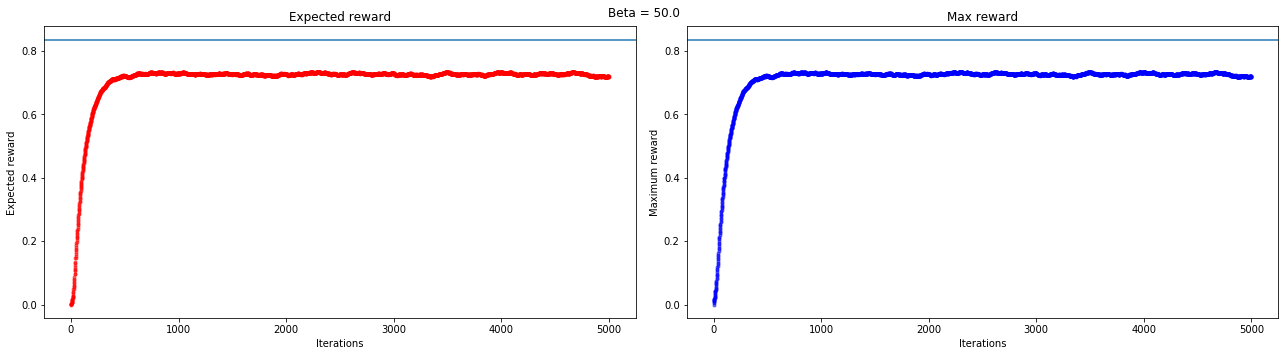

In [17]:
all_betas = [1.0, 5.0, 15.0, 50.0]

n = 5000
expected_reward = np.zeros(n)
max_reward = np.zeros(n)
lifes = 100

for beta in all_betas:
    for life in range(lifes):
        expected_reward_one_life, max_reward_one_life = get_seq(param = beta, policy_fnc = softmax, n = n)
        expected_reward += expected_reward_one_life
        max_reward += max_reward_one_life
        
    expected_reward/= lifes
    max_reward/= lifes
    
    fig, axs = plt.subplots(1, 2, figsize = (18, 5))
    axs[0].plot(expected_reward, 'ro', markersize=3, alpha = 0.5)
    axs[0].set_title("Expected reward")
    axs[0].set_xlabel('Iterations')
    axs[0].set_ylabel('Expected reward')
    axs[0].axhline(np.max(reward_prob))
    
    axs[1].plot(max_reward, 'bo', markersize=3, alpha = 0.5)
    axs[1].set_title("Max reward")
    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('Maximum reward')
    axs[1].axhline(np.max(reward_prob))

    plt.suptitle(f"Beta = {beta}")
    fig.tight_layout()
    plt.show()

**Do the results of SoftMax show any improvements compared to the epsilon-greedy policies?** 

Here we have to be careful as the number of iterations is chosen differently for the epsilon-greedy policy than for the softmax policy. However, ...
## TODO

**How does the parameter β relate to the exploration/exploitation-balance?**
A high beta corresponds to more exploitation as for beta = 50 the reward is lower than for beta = 15. However, we quickly reach a value close to the optimum as we are converging quicker than for low beta where the exploration is higher/takes longer, so for short life times a high beta would be recommended.

**And once again explain why for each β the two curves (expected reward & largest Q-value) look the way they do.**
See exploration and exploitation above. For a high beta, the difference in the probabilities for Q get larger than for low beta values. This is why for low q values the maximum reward that we find is also lower in the beginning, as states with low reward probability are still explored with relatively high probability. However, in the long run, lower beta does converge closer to the maximum reward expectation since all states have been visited so the one with the highest reward probability will definitely be found. 

### 8.

In [18]:
def generate_reward_punish(reward_prob, lever_numbers):
    rewards = np.zeros(len(lever_numbers))
    for i, lever_number in enumerate(lever_numbers):
        if lever_number == len(reward_prob)-1: 
            rewards[i] = -5000
        elif np.random.random() > reward_prob[lever_number]:
            rewards[i] = 0
        else:
            rewards[i] = 1
    return rewards

In [19]:
eps = 0.1 
beta = 15
n = 1000
lifes = 500

expected_reward_eps = np.zeros(n)
max_reward_eps = np.zeros(n)
expected_reward_beta = np.zeros(n)
max_reward_beta = np.zeros(n)

for life in range(lifes):
    expected_reward_one_life_eps, max_reward_one_life_eps = get_seq(param = eps, n = n, reward_fnc = generate_reward_punish)
    expected_reward_eps += expected_reward_one_life_eps
    max_reward_eps += max_reward_one_life_eps
    
    expected_reward_one_life_beta, max_reward_one_life_beta = get_seq(param = beta, policy_fnc = softmax, n = n, reward_fnc = generate_reward_punish)
    expected_reward_beta += expected_reward_one_life_beta
    max_reward_beta += max_reward_one_life_beta

expected_reward_eps/= lifes
max_reward_eps/= lifes
expected_reward_beta/= lifes
max_reward_beta/= lifes

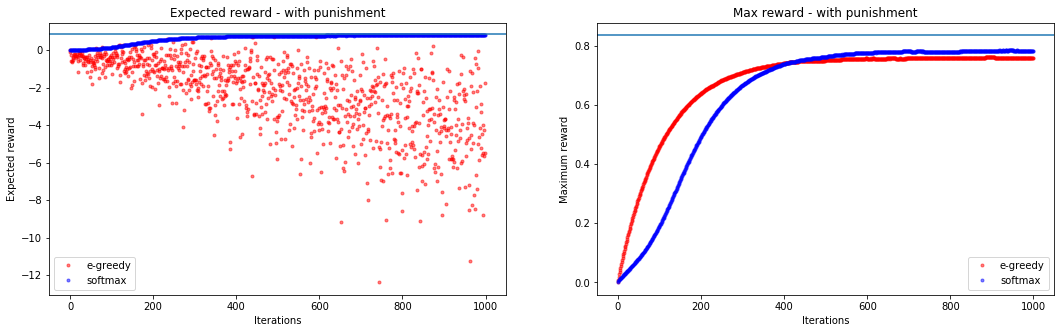

In [20]:
fig, axs = plt.subplots(1, 2, figsize = (18, 5))
axs[0].plot(expected_reward_eps, 'ro', markersize=3, alpha = 0.5, label = 'e-greedy')
axs[0].plot(expected_reward_beta, 'bo', markersize=3, alpha = 0.5, label = 'softmax')
axs[0].set_title("Expected reward - with punishment")
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Expected reward')
axs[0].axhline(np.max(reward_prob))
axs[0].legend()

axs[1].plot(max_reward_eps, 'ro', markersize=3, alpha = 0.5, label = 'e-greedy')
axs[1].plot(max_reward_beta, 'bo', markersize=3, alpha = 0.5, label = 'softmax')
axs[1].set_title("Max reward - with punishment")
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Maximum reward')
axs[1].axhline(np.max(reward_prob))
axs[1].legend()

plt.show()

**Do you observe a difference?**

We can see that the maximum reward curves both do not converge to close to the actual maximum reward, and that the e-greedy policy finds higher maximum rewards for shorter lifetimes, although the softmax policy finds a higher reward in the end. For the expected reward, it can be seen that the softmax policy is low in the beginning, but quickly converges to the maximum reward, without receiving the punishment often. The e-greedy policy, on the other hand, often receives a punishment, even at the end. 

This can be explained by how the policies work: the e-greedy policy will take a random action with probability epsilon, regardless of the value of that action, such that even actions with catastrophic results are chosen with probability epsilon. The beta softmax policy, on the other hand, weights actions based on their rewards, so a catastrophic action will have a very low weight and will be chosen almost never. 

### 9. 

In [22]:
def softmax(q, beta):
    """Return position of lever, value at this position and maximum q-value."""
    p = np.exp(beta * q)/np.sum(np.exp(beta * q))
    p_cum = np.cumsum(p)
    
    rand_el = np.random.random()
    pos =  np.argwhere(p_cum > rand_el)
    val = q[pos][0]
    max_val = np.max(q)
    
    return [pos, val, max_val]

In [23]:
b_values = [0.1, 0.4, 1.6, 6.4, 25.6]

n = 2000
expected_reward = np.zeros(n)
max_reward = np.zeros(n)
lifes = 100

for b_value in b_values:
    for i in range(lifes):
        beta = 1 + i/b_value
        expected_reward_one_life, max_reward_one_life = get_seq(param = beta, policy_fnc = softmax, n = n)
        expected_reward += expected_reward_one_life
        max_reward += max_reward_one_life
        
    expected_reward/= lifes
    max_reward/= lifes
    
    fig, axs = plt.subplots(1, 2, figsize = (18, 5))
    axs[0].plot(expected_reward, 'ro', markersize=3, alpha = 0.5)
    axs[0].set_title("Expected reward")
    axs[0].set_xlabel('Iterations')
    axs[0].set_ylabel('Expected reward')
    axs[0].axhline(np.max(reward_prob))
    
    axs[1].plot(max_reward, 'bo', markersize=3, alpha = 0.5)
    axs[1].set_title("Max reward")
    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('Maximum reward')
    axs[1].axhline(np.max(reward_prob))

    plt.suptitle(f"Beta = {beta}")
    fig.tight_layout()
    plt.show()

ValueError: non-broadcastable output operand with shape (9,1) doesn't match the broadcast shape (9,9)

Explanation: higher b at the end favors exploitation, so first we explore and then we exploit our knowledge.